# Pancreas Revisions Notebook

This notebook implements various revisions analyses on the pancreas data.

In [1]:
"""Broadly useful python packages"""
import pandas as pd
import os
import numpy as np
import pickle
from copy import deepcopy
from shutil import move
import warnings
from PIL import Image

"""Machine learning and single cell packages"""
from matplotlib import pyplot
import sklearn.metrics as metrics
from sklearn.metrics import adjusted_rand_score as ari, normalized_mutual_info_score as nmi
import scanpy as sc
from anndata import AnnData
import seaborn as sns
import holoviews as hv
import plotly.graph_objects as go
import plotly.express as pex
from holoviews.plotting.util import process_cmap

import scvi
from scvi.model import SCVI

"""CarDEC"""
from CarDEC import CarDEC_API
from CarDEC.CarDEC_utils import normalize_scanpy

%matplotlib inline

In [2]:
"""Miscellaneous useful functions"""

def read_pancreas(path, cache=True):
    """A function to read and preprocess the pancreas data"""
    pathlist = os.listdir(path)
    adata = sc.read(os.path.join(path, pathlist[0]))
          
    for i in range(1,len(pathlist)):
        adata = adata.concatenate(sc.read(os.path.join(path, pathlist[i])))

    sc.pp.filter_cells(adata, min_genes = 200)
    sc.pp.filter_genes(adata, min_cells = 30)
    mito_genes = adata.var_names.str.startswith('mt-')
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    
    notmito_genes = [not x for x in mito_genes]
    adata = adata[:,notmito_genes]
    del adata.obs['batch']
    print(adata)
    
    return(adata)

def purity_score(y_true, y_pred):
    """A function to compute cluster purity"""
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)

    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def convert_string_to_encoding(string, vector_key):
    """A function to convert a string to a numeric encoding"""
    return np.argwhere(vector_key == string)[0][0]

def convert_vector_to_encoding(vector):
    """A function to convert a vector of strings to a dense numeric encoding"""
    vector_key = np.unique(vector)
    vector_strings = list(vector)
    
    vector_num = [convert_string_to_encoding(string, vector_key) for string in vector_strings]
    
    return vector_num

def build_dir(dir_path):
    subdirs = [dir_path]
    substring = dir_path

    while substring != '':
        splt_dir = os.path.split(substring)
        substring = splt_dir[0]
        subdirs.append(substring)
        
    subdirs.pop()
    subdirs = [x for x in subdirs if os.path.basename(x) != '..']

    n = len(subdirs)
    subdirs = [subdirs[n - 1 - x] for x in range(n)]
    
    for dir_ in subdirs:
        if not os.path.isdir(dir_):
            os.mkdir(dir_)
            
def find_resolution(adata_, n_clusters, random = 0): 
    adata = adata_.copy()
    obtained_clusters = -1
    iteration = 0
    resolutions = [0., 1000.]
    
    while obtained_clusters != n_clusters and iteration < 50:
        current_res = sum(resolutions)/2
        sc.tl.louvain(adata, resolution = current_res, random_state = random)
        labels = adata.obs['louvain']
        obtained_clusters = len(np.unique(labels))
        
        if obtained_clusters < n_clusters:
            resolutions[0] = current_res
        else:
            resolutions[1] = current_res
        
        iteration = iteration + 1
        
    return current_res

metrics_ = [ari, nmi, purity_score]

Now, let's read the data in, and take a look at the cell type distribution.

View of AnnData object with n_obs × n_vars = 6321 × 21215
    obs: 'celltype', 'tech', 'n_genes', 'percent_mito', 'n_counts'
    var: 'genename', 'n_cells'
The number of cells of type: acinar is 711
The number of cells of type: activated_stellate is 180
The number of cells of type: alpha is 2281
The number of cells of type: beta is 1172
The number of cells of type: delta is 405
The number of cells of type: ductal is 1065
The number of cells of type: endothelial is 61
The number of cells of type: epsilon is 14
The number of cells of type: gamma is 359
The number of cells of type: macrophage is 24
The number of cells of type: mast is 17
The number of cells of type: quiescent_stellate is 20
The number of cells of type: schwann is 12


/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


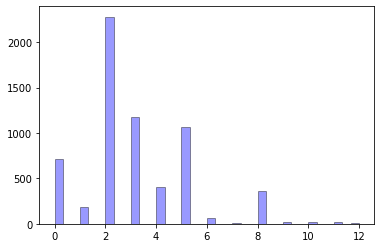

In [3]:
adata = read_pancreas("../Data/pancreas", cache=True)

celltype = adata.obs['celltype'].values
celltype_vec = convert_vector_to_encoding(celltype)

sns.distplot(celltype_vec, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

celltype_key = np.unique(adata.obs['celltype'].values)
for type_ in celltype_key:
    ntype = sum([x == type_ for x in celltype])
    print("The number of cells of type: " + type_ + " is " + str(ntype))

## Revision Evaluation: Robustness to Number of CarDEC Clusters

In this section, I analyze CarDEC's robustness to the number of clusters. This is done in three ways. First, I generate UMAP plots for various number of CarDEC cluster fits to show the overall clustering pattern remains the same. I then then generate Coefficient of Variation (CV) plots (described in the batch calibration tests notebooks) and show that the distributions of CVs remain almost the same regardless of number of clusters used. Lastly, I generate a Sankey plot which shows how each cluster splits into new clusters when increasing the number of clusters. The plot shows that in nearly all cases, increasing the number of clusters just causes big clusters to be split into smaller pieces, there is no mixing of cells from different clusters, so the overall separation of cells just gets finer.

In [4]:
n_clust = [int(x) for x in np.linspace(5, 18, 5)]

l = []
[l.extend(["UMAP1_" + str(clust), "UMAP2_" + str(clust)]) for clust in n_clust]

DF = pd.DataFrame(np.zeros((adata.shape[0], 2 + 2 * len(n_clust)), dtype = 'float32'), index = adata.obs.index, columns = ["Technology", "Cell Type"] + l)
DF['Technology'] = adata.obs['tech'].values
DF['Cell Type'] = adata.obs['celltype'].values

sankey_flow = {key: [] for key in ["Source", "Dest", "Count"]}
previous_clust = None

CVdata_ = {}

def centroid_dist(x, y, z):
    features = pd.DataFrame(x, index = range(x.shape[0]))
    Group = pd.Series(convert_vector_to_encoding(y), index = range(y.shape[0]), name="Group")
    Type = pd.Series(convert_vector_to_encoding(z), index = range(z.shape[0]), name="Type")
    Mergefeature = pd.concat([features, Group, Type],axis=1)
    n_cells = Type.value_counts().sort_index().to_numpy()

    df = Mergefeature.groupby(["Group", "Type"]).mean()
    df = df.groupby("Type").std()/(df.groupby("Type").mean() + 10**(-12)) * (n_cells/sum(n_cells))[:, None]
    return df[np.invert(np.isnan(df.to_numpy().sum(axis = 1)))].mean(axis = 0)

Trying to set attribute `.var` of view, copying.
... storing 'tech' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2463776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 19215)                2487055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  160       
Total params: 5,473,471
Trainable params: 5,473,471
Non-trainable para

... storing 'cluster assignment' as categorical
... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2463776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 19215)                2487055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

... storing 'cluster assignment' as categorical
... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2463776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 19215)                2487055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  352       
Total params: 5,473,663
Trainable params: 5,473,663
Non-trainable para

... storing 'cluster assignment' as categorical
... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2463776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 19215)                2487055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  448       
Total params: 5,473,759
Trainable params: 5,473,759
Non-trainable para

... storing 'cluster assignment' as categorical
... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2463776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 19215)                2487055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  576       
Total params: 5,473,887
Trainable params: 5,473,887
Non-trainable para

... storing 'cluster assignment' as categorical


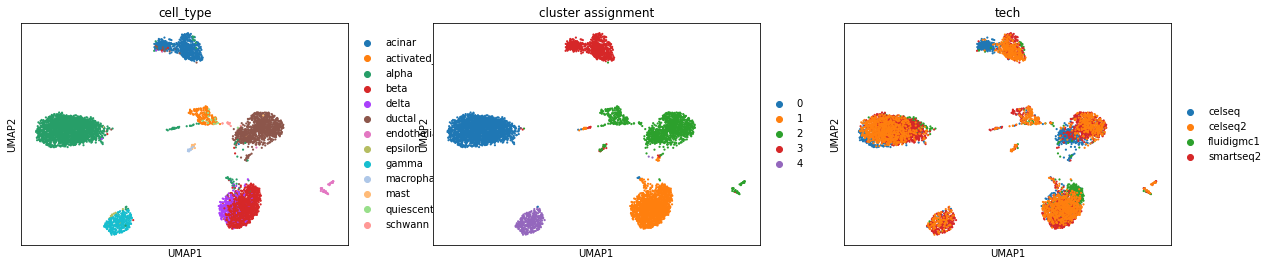

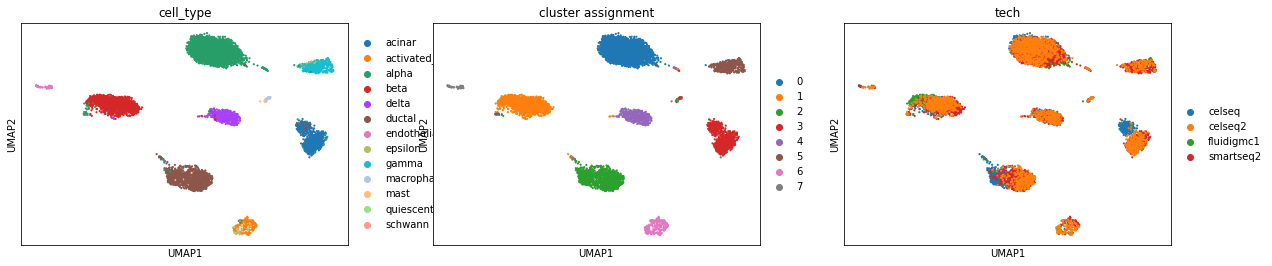

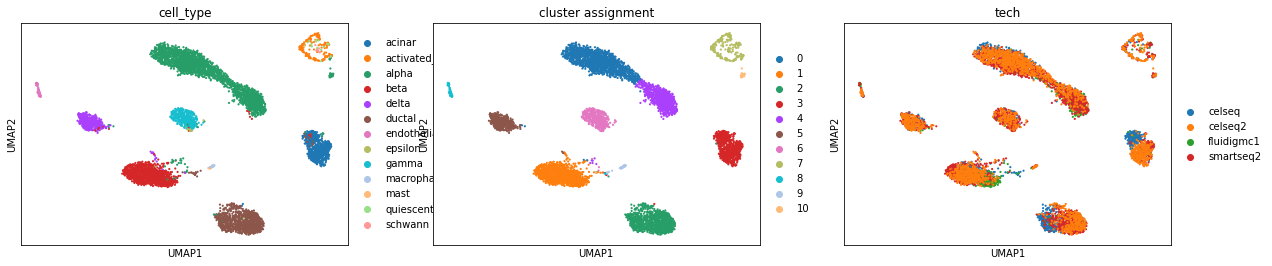

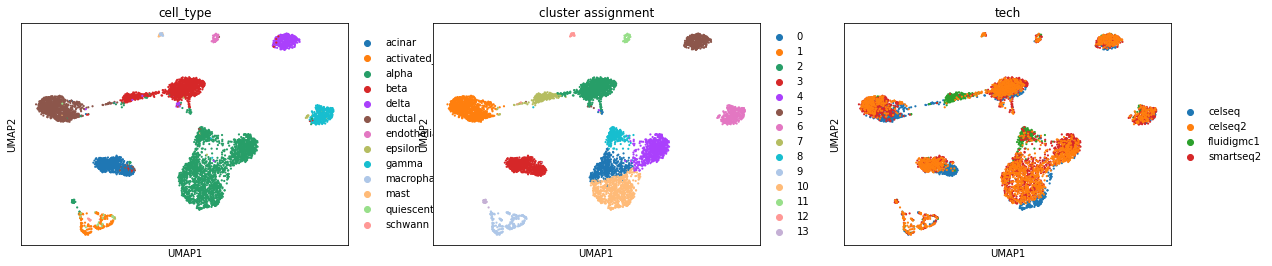

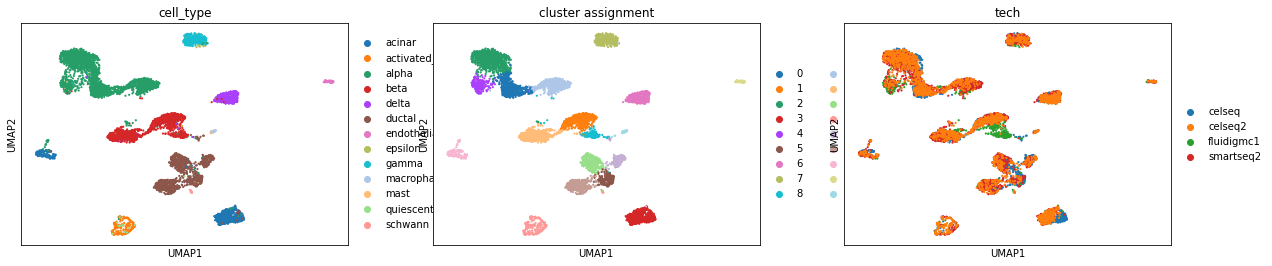

In [5]:
for clust in n_clust:
    CarDEC = CarDEC_API(adata, weights_dir = "Pancreas Clust Eval/Weights Clust_" + str(clust), batch_key = 'tech', n_high_var = 2000)
    CarDEC.build_model(n_clusters = clust)
    CarDEC.make_inference()
    CarDEC.model_counts()
    
    temporary = AnnData(CarDEC.dataset.obsm['embedding'])
    temporary.obs = CarDEC.dataset.obs
    temporary.obs['cell_type'] = temporary.obs['celltype']

    sc.tl.pca(temporary, svd_solver='arpack')
    sc.pp.neighbors(temporary, n_neighbors = 15)

    q = CarDEC.dataset.obsm['cluster memberships']
    labels = np.argmax(q, axis=1)
    temporary.obs['cluster assignment'] = [str(x) for x in labels]

    sc.tl.umap(temporary)
    sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "tech"], return_fig = True)

    DF[['UMAP1_' + str(clust), 'UMAP2_' + str(clust)]] = temporary.obsm['X_umap']
    DF["Labels_" + str(clust)] = labels
    
    n, p = adata.shape
    FPlist = centroid_dist(CarDEC.dataset.layers['denoised counts'], CarDEC.dataset.obs['tech'], CarDEC.dataset.obs['cell_type'])
    CVdata_["n_clust = " + str(clust)] = FPlist
        
    if previous_clust is not None:
        cell_identities = np.concatenate((previous_clust[:, None], labels[:, None]), axis = 1)
        
        value_count = {}
        for cell in cell_identities:
            cell = str(cell.tolist())

            if cell not in value_count.keys():
                value_count[cell] = 0

            value_count[cell] += 1
            
        sources, dests = np.asarray([eval(x) for x in value_count.keys()]).T
        
        sankey_flow["Source"].extend([str(x) + " {" + str(prev) + " clusters}" for x in sources])
        sankey_flow["Dest"].extend([str(x) + " {" + str(clust) + " clusters}" for x in dests])
        sankey_flow["Count"].extend(list(value_count.values()))
    
    prev = clust
    previous_clust = labels

In [6]:
base_path = "../Figures/pancreas_revisions"
if not os.path.isdir(base_path):
    build_dir(base_path)

DF.to_csv(os.path.join(base_path, "CVs_nclust.csv"))

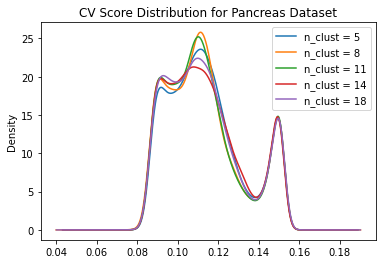

In [7]:
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
myplot.set_title("CV Score Distribution for Pancreas Dataset")

"""Figure info for paper"""
path = os.path.join(base_path, 'CVs')

myplot = myplot.get_figure()
myplot.savefig(path + '.png', dpi=300)
im = Image.open(path + '.png')
im.save(path + '.tiff')

In [11]:
cmap_list = process_cmap("glasbey_hv")
cl = {n: cmap_list[idx] for idx, n in enumerate(n_clust)}
cl[14] = cmap_list[33]
cl[18] = cmap_list[248]

cmap = {node: cl[int(node[node.find("{") + 1:node.find("}") - len('clusters')])] for node in np.unique(np.concatenate((sankey_flow["Source"], sankey_flow["Dest"])))}

# sankey.opts(width=600, height=400, cmap=cmap)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

Unexpected style option 'edge_line_width' for Sankey in loaded backend 'matplotlib'.

Similar keywords in the currently active 'matplotlib' renderer are: ['edge_linewidth', 'node_linewidth', 'edge_linestyle']

If you believe this keyword is correct, please make sure the backend has been imported or loaded with the hv.extension.Unexpected style option 'edge_hover_fill_color' for Sankey in loaded backend 'matplotlib'.

Similar keywords in the currently active 'matplotlib' renderer are: ['edge_color']

If you believe this keyword is correct, please make sure the backend has been imported or loaded with the hv.extension.Unexpected plot option 'height' for Sankey in loaded backend 'matplotlib'.

Possible keywords in the currently active 'matplotlib' renderer are: ['apply_extents', 'apply_ranges', 'apply_ticks', 'arrowhead_length', 'aspect', 'bgcolor', 'cbar_extend', 'cbar_padding', 'cbar_ticks', 'cbar_width', 'cformatter', 'clabel', 'clim', 'clim_percentile', 'clipping_colors', 'cnorm', 'co

:Sankey   [Source,Dest]   (Count)
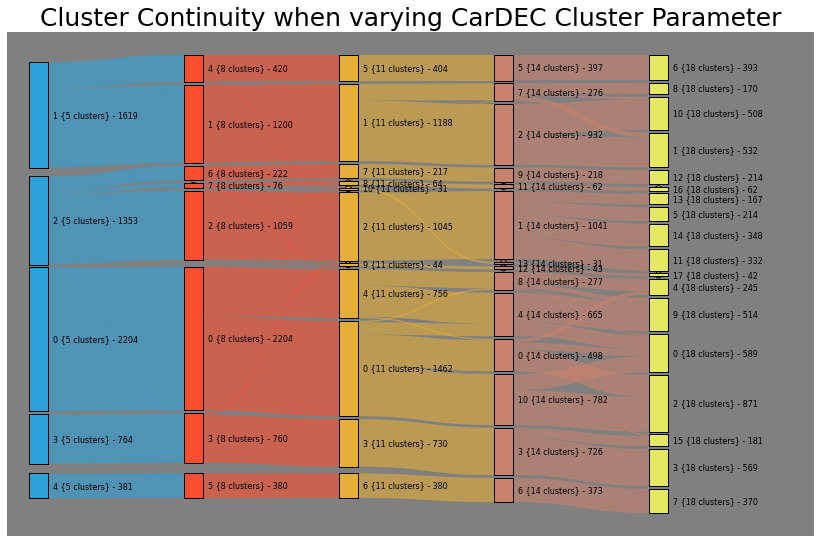

In [12]:
hv.extension('matplotlib')

%opts Sankey (edge_color="Source"  edge_line_width=2 node_cmap="tab20")
%opts Sankey (node_alpha=1.0 edge_hover_fill_color="red")
%opts Sankey [node_sort=False label_position='right' node_width=30 node_sort=True ]
%opts Sankey [title="Cluster Continuity when varying CarDEC Cluster Parameter" width=1800 height=1400]
%opts Sankey [margin=0 padding=0 bgcolor="grey"]

plot = hv.Sankey(sankey_flow, kdims=["Source", "Dest"], vdims=["Count"]).opts(fontsize={'title': 25}, cmap=cmap)

path = os.path.join(base_path, 'sankey')
hv.save(plot, path + ".png")
im = Image.open(path + '.png')
im.save(path + '.tiff')

plot

## Revision Evaluation: Robustness to Clustering Loss Weight

Next, I evaluate CarDEC's robustness to the clustering weight parameter. To do this, I simply vary the clustering weight, and record the ARI (for HVGs and LVGs separately) as this parameter varies. My results show that ARI does not depend much on this parameter's tuning.

In [13]:
factors = np.linspace(0.1, 1.9, 5)

ARIs = pd.DataFrame(np.zeros((len(factors), 2)), index = factors, columns = ["HVG", "LVG"])

adata = read_pancreas("../Data/pancreas", cache=True)

View of AnnData object with n_obs × n_vars = 6321 × 21215
    obs: 'celltype', 'tech', 'n_genes', 'percent_mito', 'n_counts'
    var: 'genename', 'n_cells'


In [14]:
for factor in factors:
    CarDEC = CarDEC_API(adata, weights_dir = "Pancreas LossParam Eval/Weights Factor_" + str(factor), batch_key = 'tech', n_high_var = 2000)
    CarDEC.build_model(n_clusters = 8, clust_weight = factor)
    CarDEC.make_inference()
    
    
    
    temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised'][:, CarDEC.dataset.var['Variance Type'] == 'HVG']))
    temporary.obs = CarDEC.dataset.obs
    temporary.obs['cell_type'] = temporary.obs['celltype']

    sc.tl.pca(temporary, svd_solver='arpack')
    sc.pp.neighbors(temporary, n_neighbors = 15)

    res = find_resolution(temporary, 8)
    sc.tl.louvain(temporary, resolution = res)
    temporary.obs['cluster assignment'] = temporary.obs['louvain']

    ARIs.loc[factor]["HVG"], NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]


    
    temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised'][:, CarDEC.dataset.var['Variance Type'] == 'LVG']))
    temporary.obs = CarDEC.dataset.obs
    temporary.obs['cell_type'] = temporary.obs['celltype']

    sc.tl.pca(temporary, svd_solver='arpack')
    sc.pp.neighbors(temporary, n_neighbors = 15)

    res = find_resolution(temporary, 8)
    sc.tl.louvain(temporary, resolution = res)
    temporary.obs['cluster assignment'] = temporary.obs['louvain']

    ARIs.loc[factor]["LVG"], NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

Trying to set attribute `.var` of view, copying.
... storing 'tech' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2463776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 19215)                2487055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2463776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 19215)                2487055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2463776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 19215)                2487055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2463776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 19215)                2487055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2463776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 19215)                2487055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

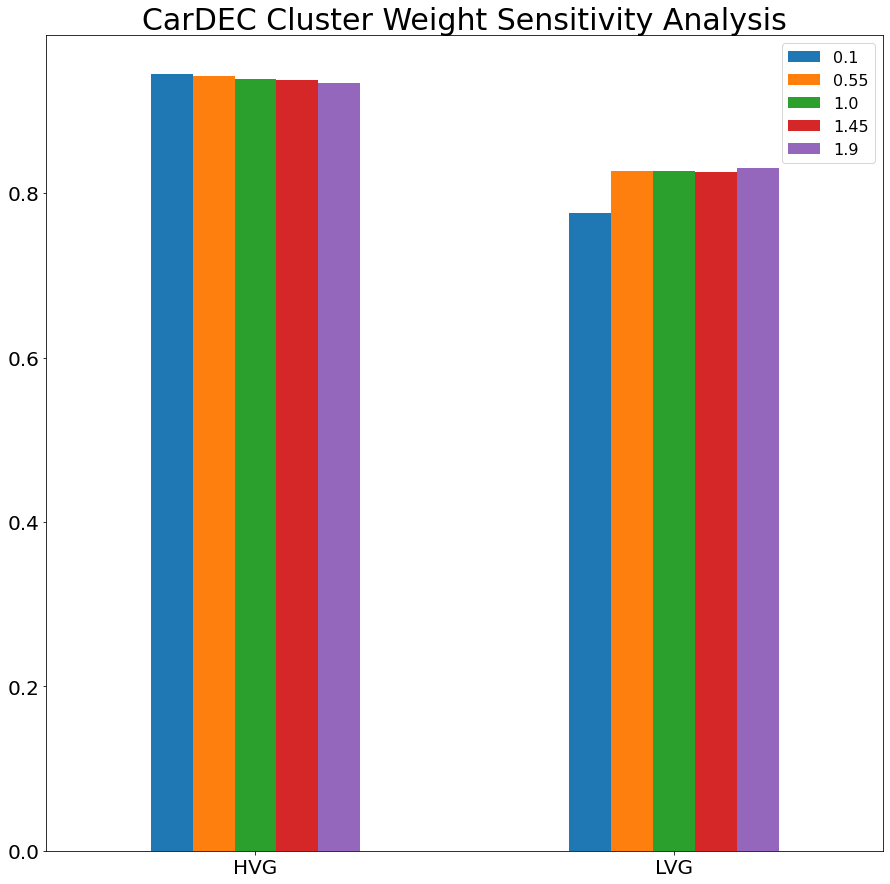

In [15]:
ARIs.index = [str(round(x, 2)) for x in ARIs.index]

f = 20
pyplot.rc('xtick', labelsize = f)    # fontsize of the tick labels
pyplot.rc('ytick', labelsize = f)    # fontsize of the tick labels

ax = ARIs.T.plot.bar(rot = 0, figsize = (15 , 15))
ax.legend(loc = 1, prop = {'size': 16})

ax.set_title("CarDEC Cluster Weight Sensitivity Analysis", size = 30)

"""Figure info for paper"""
path = os.path.join(base_path, 'clustweight_sensitivity')

ax = ax.get_figure()
ax.savefig(path + '.png', dpi=300)
im = Image.open(path + '.png')
im.save(path + '.tiff')

## Revision Evaluation: Robustness to number of HVGs

Now, I evaluate CarDEC's robustness to the number of HVGs selected. To do this, I pick the bottom 21215 - 5000 = 16215 genes by variability, and I measure the ARI of a louvain clustering on these genes after correcting them using CarDEC, with the number of HVGs selected for CarDEC varing from 500 to 5000 genes. In the barplot, we see that the ARI on the LVGs increases slightly when n_HVG increases from 500 to 1000, and then remains stable from 1000 to 3000, after which it drops by slightly more than 0.1, likely because the HVGs were becoming too noisy as we lowered the threshold for selecting an HVG.

In [16]:
HVG_set = [500 * i for i in range(10, 0, -1)]
ARIs = pd.Series(np.zeros((len(HVG_set),), dtype = 'float32'), index = HVG_set)

adata = read_pancreas("../Data/pancreas", cache=True)

View of AnnData object with n_obs × n_vars = 6321 × 21215
    obs: 'celltype', 'tech', 'n_genes', 'percent_mito', 'n_counts'
    var: 'genename', 'n_cells'


In [17]:
for n_HVG in HVG_set:
    CarDEC = CarDEC_API(adata, weights_dir = "Pancreas nHVG Eval/HVG Number_" + str(n_HVG), batch_key = 'tech', n_high_var = n_HVG)
    CarDEC.build_model(n_clusters = 8)
    CarDEC.make_inference()

    if n_HVG == HVG_set[0]:
        common_genes = CarDEC.dataset.var.index[CarDEC.dataset.var['Variance Type'] == 'LVG']

    temporary = AnnData(deepcopy(CarDEC.dataset[:, common_genes].layers['denoised']))
    temporary.obs = CarDEC.dataset.obs
    temporary.obs['cell_type'] = temporary.obs['celltype']

    sc.tl.pca(temporary, svd_solver = 'arpack')
    sc.pp.neighbors(temporary, n_neighbors = 15)

    res = find_resolution(temporary, 8)
    sc.tl.louvain(temporary, resolution = res)
    temporary.obs['cluster assignment'] = temporary.obs['louvain']

    ARIs[n_HVG], NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

Trying to set attribute `.var` of view, copying.
... storing 'tech' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                644256    
_________________________________________________________________
decoder (Sequential)         (None, 5000)              649224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2079776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 16215)                2100055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                580256    
_________________________________________________________________
decoder (Sequential)         (None, 4500)              584724    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2143776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 16715)                2164555   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                516256    
_________________________________________________________________
decoder (Sequential)         (None, 4000)              520224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2207776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 17215)                2229055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                452256    
_________________________________________________________________
decoder (Sequential)         (None, 3500)              455724    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2271776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 17715)                2293555   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                388256    
_________________________________________________________________
decoder (Sequential)         (None, 3000)              391224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2335776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 18215)                2358055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                324256    
_________________________________________________________________
decoder (Sequential)         (None, 2500)              326724    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2399776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 18715)                2422555   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2463776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 19215)                2487055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                196256    
_________________________________________________________________
decoder (Sequential)         (None, 1500)              197724    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2527776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 19715)                2551555   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                132256    
_________________________________________________________________
decoder (Sequential)         (None, 1000)              133224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2591776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 20215)                2616055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                68256     
_________________________________________________________________
decoder (Sequential)         (None, 500)               68724     
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2655776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 20715)                2680555   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

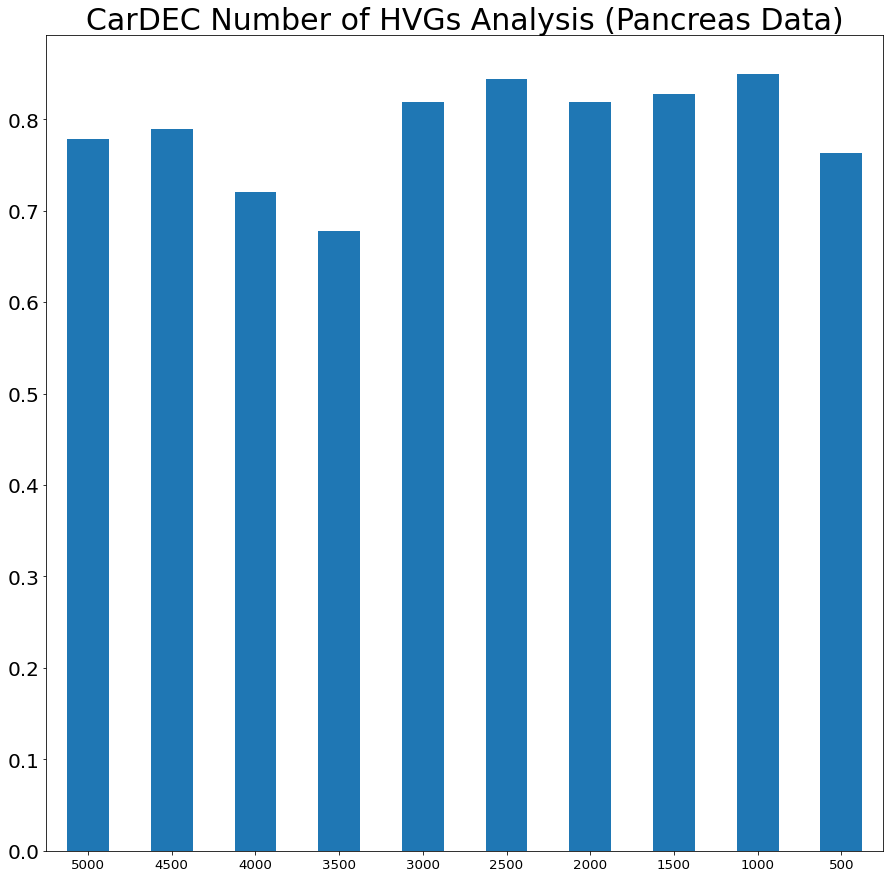

In [18]:
ARIs.index = [str(round(x, 2)) for x in ARIs.index]

f = 20
pyplot.rc('xtick', labelsize = f/1.5)    # fontsize of the tick labels
pyplot.rc('ytick', labelsize = f)    # fontsize of the tick labels

ax = ARIs.T.plot.bar(rot = 0, figsize = (15 , 15))
ax.set_title("CarDEC Number of HVGs Analysis (Pancreas Data)", size = 30)

"""Figure info for paper"""
path = os.path.join(base_path, 'nHVG_analysis_pancreas')

ax = ax.get_figure()
ax.savefig(path + '.png', dpi=300)
im = Image.open(path + '.png')
im.save(path + '.tiff')

## Revision Evaluation: No within-batch normalization

Lastly, I evaluate CarDEC's performance if I remove within batch feature normalization. In this evaluation, I instead do feature normalization once across all batches.

In [19]:
ARI_data_gene = {'ARI': [0] * 4,
            'NMI': [0] * 4,
            'Purity': [0] * 4,
           'Method': ['Full Data Norm'] * 2 + ['Norm by Batch'] * 2,
                'Type': ['HVG', 'LVG'] * 2}
ARI_data_gene = pd.DataFrame(ARI_data_gene)

figure_path_supplement = "../Figures/pancreas_supplement"

In [20]:
adata = read_pancreas("../Data/pancreas", cache=True)
tmp = adata.copy()
tmp = normalize_scanpy(adata, n_high_var = 2000, batch_key = 'tech')

View of AnnData object with n_obs × n_vars = 6321 × 21215
    obs: 'celltype', 'tech', 'n_genes', 'percent_mito', 'n_counts'
    var: 'genename', 'n_cells'


Trying to set attribute `.var` of view, copying.
... storing 'tech' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [21]:
adata2 = adata.copy()
sc.pp.normalize_total(adata2)
sc.pp.log1p(adata2)
sc.pp.scale(adata2)

adata.layers['normalized input'] = adata2.X.copy()
adata.var['Variance Type'] = tmp.var['Variance Type']

In [22]:
CarDEC = CarDEC_API(adata, weights_dir = "Pancreas All/datawide_scale Weights", batch_key = 'tech', n_high_var = 2000, preprocess = False)

In [23]:
CarDEC.build_model(n_clusters = 8)

Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2463776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 19215)                2487055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

In [24]:
CarDEC.make_inference()

Weight index file detected, loading weights.
CarDEC Model weights loaded successfully.

The CarDEC model is now making inference on the data matrix.
Inference completed, results returned.
 


CarDEC high variance denoised features
ARI = 0.5653
NMI = 0.7300
Purity = 0.8208


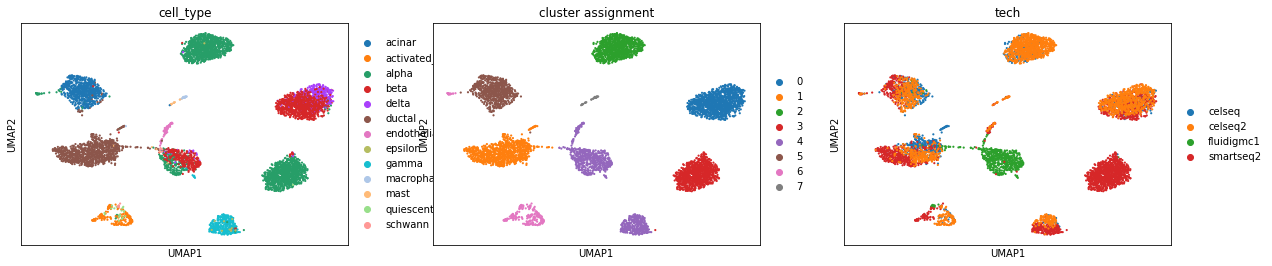

In [25]:
"""Assessing denoised zscore features for high variance features"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised'][:, CarDEC.dataset.var['Variance Type'] == 'HVG']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['celltype']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 8)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "tech"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("CarDEC high variance denoised features")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

"""Figure info for main paper"""
DF = pd.DataFrame(temporary.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Technology'] = temporary.obs['tech'].values
DF['Cell Type'] = temporary.obs['celltype'].values
DF.index = temporary.obs.index

base_path = ARI_data_gene.iloc[0,3] + "_" + ARI_data_gene.iloc[0,4] + ".csv"
path = os.path.join(figure_path_supplement, base_path)
ARI_data_gene.iloc[0,:3] = ARI, NMI, Purity

DF.to_csv(path)

Clustering low variance denoised features
ARI = 0.2578
NMI = 0.4069
Purity = 0.5937


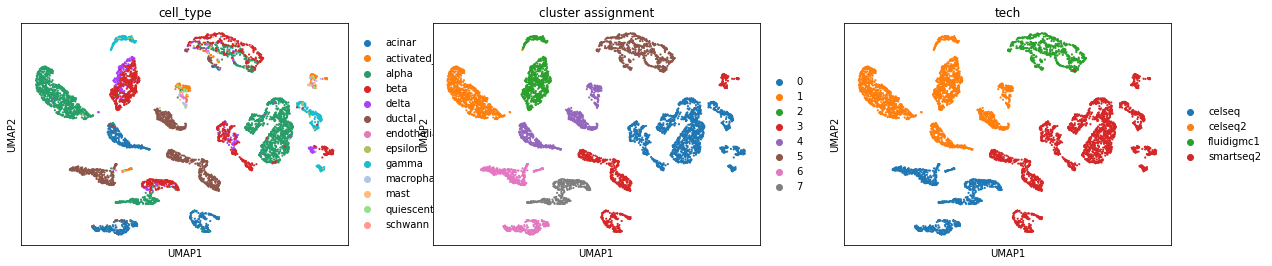

In [26]:
"""Assessing denoised zscore features for low variance features"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised'][:, CarDEC.dataset.var['Variance Type'] == 'LVG']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['celltype']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 8)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "tech"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("Clustering low variance denoised features")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

"""Figure info for paper"""
DF = pd.DataFrame(temporary.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Technology'] = temporary.obs['tech'].values
DF['Cell Type'] = temporary.obs['celltype'].values
DF.index = temporary.obs.index

base_path = ARI_data_gene.iloc[1,3] + "_" + ARI_data_gene.iloc[1,4] + ".csv"
path = os.path.join(figure_path_supplement, base_path)
ARI_data_gene.iloc[1,:3] = ARI, NMI, Purity

DF.to_csv(path)

In [27]:
adata = read_pancreas("../Data/pancreas", cache=True)

CarDEC = CarDEC_API(adata, weights_dir = "Pancreas All/CarDEC_LVG Weights", batch_key = 'tech', n_high_var = 2000)
CarDEC.build_model(n_clusters = 8)
CarDEC.make_inference()

View of AnnData object with n_obs × n_vars = 6321 × 21215
    obs: 'celltype', 'tech', 'n_genes', 'percent_mito', 'n_counts'
    var: 'genename', 'n_cells'


Trying to set attribute `.var` of view, copying.
... storing 'tech' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2463776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 19215)                2487055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

CarDEC high variance denoised features
ARI = 0.9326
NMI = 0.9076
Purity = 0.9592


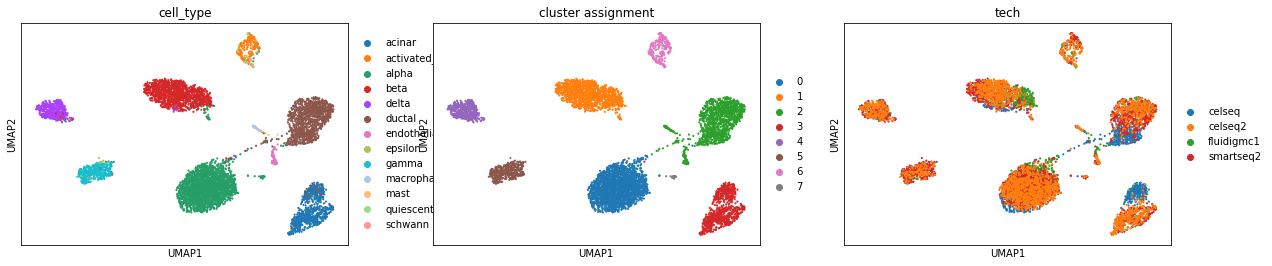

In [28]:
"""Assessing denoised zscore features for high variance features"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised'][:, CarDEC.dataset.var['Variance Type'] == 'HVG']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['celltype']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 8)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "tech"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("CarDEC high variance denoised features")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

"""Figure info for main paper"""
DF = pd.DataFrame(temporary.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Technology'] = temporary.obs['tech'].values
DF['Cell Type'] = temporary.obs['celltype'].values
DF.index = temporary.obs.index

base_path = ARI_data_gene.iloc[2,3] + "_" + ARI_data_gene.iloc[2,4] + ".csv"
path = os.path.join(figure_path_supplement, base_path)
ARI_data_gene.iloc[2,:3] = ARI, NMI, Purity

DF.to_csv(path)

Clustering low variance denoised features
ARI = 0.8261
NMI = 0.8342
Purity = 0.8988


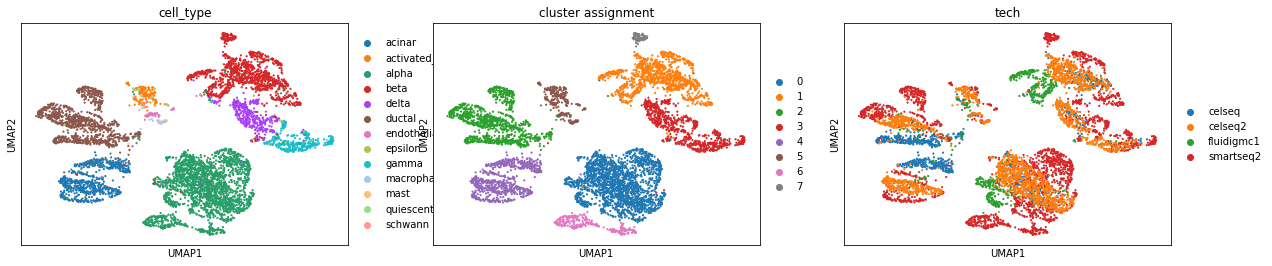

In [29]:
"""Assessing denoised zscore features for low variance features"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised'][:, CarDEC.dataset.var['Variance Type'] == 'LVG']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['celltype']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 8)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "tech"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("Clustering low variance denoised features")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

"""Figure info for paper"""
DF = pd.DataFrame(temporary.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Technology'] = temporary.obs['tech'].values
DF['Cell Type'] = temporary.obs['celltype'].values
DF.index = temporary.obs.index

base_path = ARI_data_gene.iloc[3,3] + "_" + ARI_data_gene.iloc[3,4] + ".csv"
path = os.path.join(figure_path_supplement, base_path)
ARI_data_gene.iloc[3,:3] = ARI, NMI, Purity

DF.to_csv(path)

base_path = 'ARIs_normbybatch.csv'
path = os.path.join(figure_path_supplement, base_path)
ARI_data_gene.to_csv(path)